<div style="text-align:right">Peter Norvig<br>21 March 2018</div>
# `xkcd` Name Dominoes

The March 21, 2018 `xkcd` comic number 1970 was [Name Dominoes](https://xkcd.com/1970/): domino tiles laid out in a legal array,
but with each tile having names of famous poeple rather than numbers. In regular [dominoes](https://en.wikipedia.org/wiki/Dominoes), each tile has two halves, and a tile can be legally placed only if  one half is adjacent to another tile with the same number/name, and neither half is adjacent to any tile with a different number/name. (The very first tile in a game has no adjacent tiles, so it can be placed anywhere.) `xkcd 1970` makes two exceptions to the rules: (1) some tiles have three names, and matches are allowed against the middle name, and (2) approximate matches are allowed, like "Amy" and "Aimee".

I will write a function to lay out dominoes in a random, legal array. I won't implement the two `xkcd` exceptions. I'll start with two key data structures:

- **`Board(n)`**: Creates an [n × n] 2-dimensional array of locations; each location holds as a value one half of a tile, or it can be `empty`, or it can be a `border`, meaning nothing can be placed there.
- **`tiles(text)`**: a function to create a list of tiles, each of which is a 2-element list, like `['a', 'b']`, indicating the two halves. The input is a string, consisting of space-separated tiles, where the two halves of the tile are separated by a `|` character.



In [1]:
empty  = '  '
border = '--'

class Board(list):
    "A board is a 2d array of values."
    
    def __init__(self, n): 
        "Initialize an [n × n] array of `empty`, surrounded by `off`"
        top = bot = [border] * (n + 2)
        line = [border] + ([empty] * n) + [border]
        self.extend([top] + [list(line) for _ in range(n)] + [bot])
        
    def get(self, loc): return self[loc[1]][loc[0]]
    
    def put(self, loc, value): self[loc[1]][loc[0]] = value
        
def tiles(text):
    "tiles('a|b b|c') => [['a', 'b'], ['b', 'c']"
    return [tile.split('|') for tile in text.split()]


names1 = tiles('Bo|Ja Ja|Ry Ja|Po Ry|Ke Gr|Ke Gr|Ho Bo|Po Ry|Ja')

In [2]:
Board(4)

[['--', '--', '--', '--', '--', '--'],
 ['--', '  ', '  ', '  ', '  ', '--'],
 ['--', '  ', '  ', '  ', '  ', '--'],
 ['--', '  ', '  ', '  ', '  ', '--'],
 ['--', '  ', '  ', '  ', '  ', '--'],
 ['--', '--', '--', '--', '--', '--']]

In [3]:
names1

[['Bo', 'Ja'],
 ['Ja', 'Ry'],
 ['Ja', 'Po'],
 ['Ry', 'Ke'],
 ['Gr', 'Ke'],
 ['Gr', 'Ho'],
 ['Bo', 'Po'],
 ['Ry', 'Ja']]

Now I need a strategy to fill the board with tiles, legally.  I will randomly place dominoes one at a time, and I will *not* consider removing a tile from the board and backtracking; this is a greedy search. Some more concepts:

- **`frontier`**: I'll maintain a *frontier*, a set of locations that are adjacent to tiles on the board, and thus are candidates for placing new tiles.
- **`dominoes(tiles)`**: places a random tile for the first tile, then repeatedly calls `place1` to legally place an additional tile, stopping when either there is no `frontier` left (meaning no place to put a tile) or no `tiles` left to place.
- **`place1(tiles, board, frontier)`**: find a location in the frontier, such that some tile can legally put one of its halves there, and the other half on an adjacent location; when found, `put` the tile there, and remove it from `tiles`.
- **`legal(value, loc, board)`**: a value can be placed in a location if the location is empty, and no neighboring location has a different value (but it is ok if a neighbor is empty or is a border).
- **`neighbors(loc)`**: returns the four neighbors of a location.
- **`put(board, loc0, loc1, tile, frontier)`**: places a tile on the board, it accomplishes this by making two calls to the board's `put` method, one for each half of the tile. The `put` function also updates the `frontier` to say that the just-covered locations are no longer in the frontier, but the empty neighbors of the tile are.
- **`shuffle(sequence)`**: used to randomize lists; calls `random.shuffle` and returns the result.

In [4]:
import random

def dominoes(tiles, n=6):
    "Place as many tiles on board as possible, legally and randomly."
    tiles    = shuffle(list(tiles))
    board    = Board(n)
    frontier = set()
    m        = n // 2
    put(board, (m, m), (m, m + 1), tiles.pop(), frontier) # Place first tile
    while tiles and frontier:
        place1(tiles, board, frontier)
    return board
          
def place1(tiles, board, frontier):
    "Randomly place one tile on board, on some frontier location and an adjacent square."
    for loc0 in shuffle(frontier):
        frontier.discard(loc0)
        for tile in shuffle(tiles):
            for (v, w) in [tile, tile[::-1]]:
                if legal(v, loc0, board):
                    for loc1 in shuffle(neighbors(loc0)):
                        if legal(w, loc1, board):
                            put(board, loc0, loc1, [v, w], frontier)
                            tiles.remove(tile)
                            return  
                        
def legal(value, loc, board):
    "Is it legal to place this value on this location on board?"
    return (board.get(loc) is empty and
            all(board.get(nbr) in (empty, border, value) 
                for nbr in neighbors(loc)))

def neighbors(loc):
    "Neighbors of this location."
    x, y = loc
    return ((x, y+1), (x, y-1), (x+1, y), (x-1, y)) 

def put(board, loc0, loc1, tile, frontier): 
    "Place the tile across the two locations, and update frontier."
    board.put(loc0, tile[0])
    board.put(loc1, tile[1])
    frontier -= {loc0, loc1}
    frontier |= {loc for loc in neighbors(loc0) + neighbors(loc1)
                 if board.get(loc) is empty}
                            
def shuffle(seq):
    "Return seq as a shuffled list."
    if not isinstance(seq, list): seq = list(seq)
    random.shuffle(seq)
    return seq
    
dominoes(names1)

[['--', '--', '--', '--', '--', '--', '--', '--'],
 ['--', '  ', 'Po', 'Ja', 'Ja', 'Ry', '  ', '--'],
 ['--', '  ', 'Po', '  ', '  ', 'Ry', 'Ke', '--'],
 ['--', '  ', 'Bo', 'Bo', '  ', '  ', 'Ke', '--'],
 ['--', '  ', '  ', 'Ja', '  ', '  ', 'Gr', '--'],
 ['--', '  ', '  ', 'Ja', 'Ry', '  ', 'Gr', '--'],
 ['--', '  ', '  ', '  ', '  ', '  ', 'Ho', '--'],
 ['--', '--', '--', '--', '--', '--', '--', '--']]

# Pretty Output

There are two problems with this output. One, it is ugly. Two, I can't easily tell where each domino is: when three names come together, which of the outside ones go with the middle one?  To fix those two problems I will:

- Use `matplotlib` to plot a less-ugly display, by defining `plot_board(board)`.
- Modify the `Board` class and the `put` function so that the board maintains a list of `boxes` that surround each tile once it is placed on the board.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_board(board, size=6):
    plt.figure(figsize=(size, size))
    plt.axis('off')  
    plt.axis('equal')
    for (x0, y0, x1, y1) in board.boxes:
        plt.plot([x0, x1, x1, x0, x0], 
                 [y0, y0, y1, y1, y0], 'k-')
    for (y, row) in enumerate(board):
        for (x, val) in enumerate(row):
            if val is not border:
                plt.text(x + 0.5, y + 0.3, val, ha='center', fontsize=9)
                
class Board(list):
    "A board is a 2d array of values."
    
    def __init__(self, n): 
        "Initialize an [n × n] array of `empty`, surrounded by `off`"
        top = bot = [border] * (n + 2)
        line = [border] + ([empty] * n) + [border]
        self.extend([top] + [list(line) for _ in range(n)] + [bot])
        self.boxes = []
        
    def get(self, loc): return self[loc[1]][loc[0]]
    
    def put(self, loc, value): self[loc[1]][loc[0]] = value
        
        
def put(board, loc0, loc1, tile, frontier): 
    "Place the tile across the two locations, and update frontier."
    board.put(loc0, tile[0])
    board.put(loc1, tile[1])
    frontier -= {loc0, loc1}
    frontier |= {loc for loc in neighbors(loc0) + neighbors(loc1)
                 if board.get(loc) is empty}
    (x0, y0), (x1, y1) = loc0, loc1
    board.boxes.append((min(x0, x1), min(y0, y1), max(x0, x1) + 1, max(y0, y1) + 1))

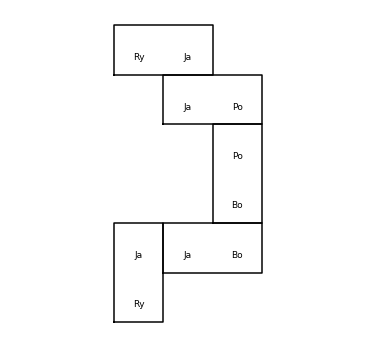

In [6]:
plot_board(dominoes(names1))

# Scaling Up Names

Now let's try with more tiles, with names taken (mostly) from `xkcd 1970`.

I could modify the program to back up if it got stuck before placing all the tiles, but instead I'll just add a new function, `best_dominoes(tiles, repeat=R)` that calls `dominoes` R times, and returns (and optionally prints) the
board that has placed the most tiles (which we can measure with `len(board.boxes)`).

In [7]:
names2 = tiles(
    'The|Rock Chris|Rock Rock|Hudson Chris|Isaac Isaac|Newton Olivia|Newton Isaac|Hayes '
    'Shawn|Hayes Wallace|Shawn Charles|Wallace George|Wallace Charles|Manson Ray|Charles '
    'Rachel|Ray Ray|Allen Tim|Allen Lily|Allen Tim|Cook James-Earl|Ray James-Earl|Jones '
    'Man|Ray Bat|Man Super|Man Tim|Howard Ron|Howard Ron|Paul Paul|Allen Rand|Paul Ayn|Rand '
    'Paul|Ryan Jack|Ryan Debby|Ryan Paul|Simon Carly|Simon John|Kelly Megyn|Kelly John|Henry '
    'Grace|Kelly Grace|Jones Grace|Hopper Jack|Ma Ma|Bell Yo-Yo|Ma Jack|Ruby Jack|Russell '
    'Charles|Parker Marilyn|Manson Marilyn|Monroe James|Monroe George|Bush George|Clinton Bill|Clinton '
    'Jack|White Meg|Ryan Meg|White Barry|White Walter|White Betty|White Betty|Ford Henry|Ford Harrison|Ford '
    'Tommy|John John|Irving John|Kerry Kerry|Washington Jimmy|John John|Adams Amy|Adams Amy|Man '
    'Benjamin|Harrison Benjamin|Franklin Aretha|Franklin Franklin|Graham James|Garfield Garfield| '
    'Kristen|Bell Kristen|Stewart Martha|Stewart Martha|Washington Wsshington|Irving John|Irving '
    'Jimmy|Buffett Jimmy|Jones Warren|Buffett Elizabeth|Warren '
    'Kevin|Bacon Kevin|Kline Kevin|Love Kevin|Smith Kevin|Costner Will|Smith Tommy|Lee Robert-E|Lee '
    'John|Wayne Wayne|Newton Wayne|Knight Wayne|Howard Wayne|Brady Tommy|Brady James|Brady')

def best_dominoes(tiles, n=20, size=16, verbose=True, repeat=300):
    board = max((dominoes(tiles, n) for _ in range(repeat)), 
                key=lambda board: len(board.boxes))
    if verbose:
        print(len(board.boxes), '/', len(tiles), 'tiles placed')
        plot_board(board, size)
    return board

84 / 100 tiles placed


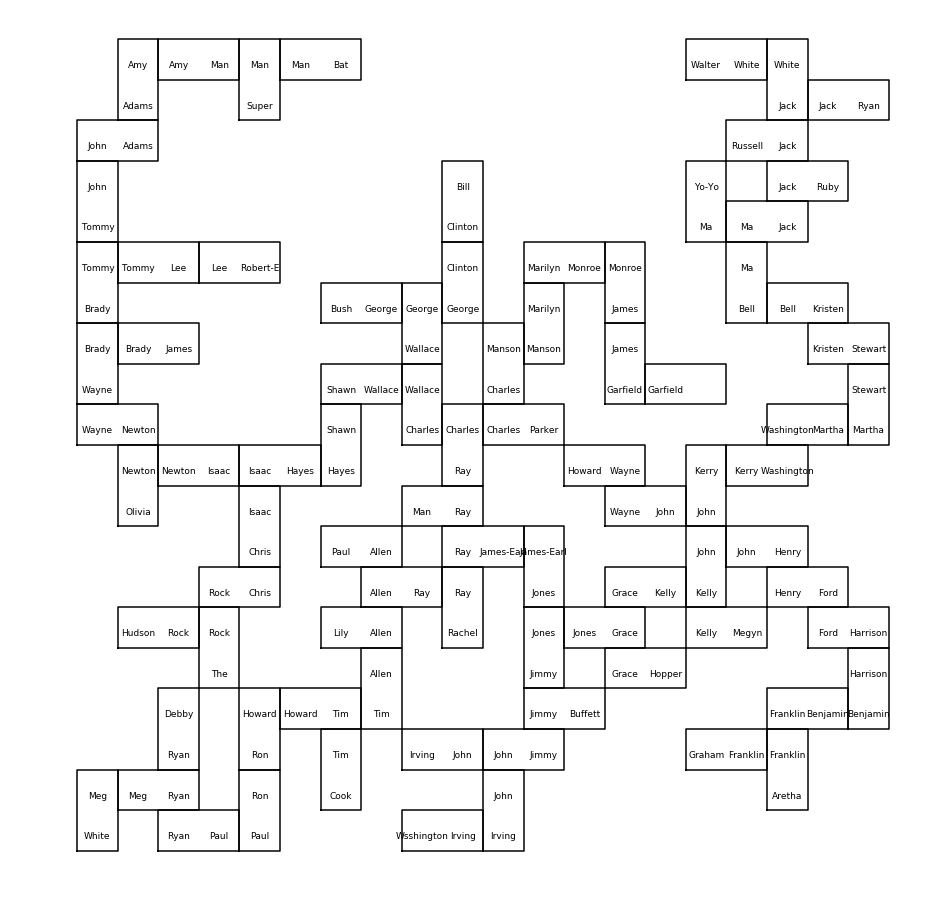

In [8]:
best_dominoes(names2);